In [1]:
import requests 
import numpy as np
import pandas as pd
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
g = 'POLYGON ((-122.0625 38.0625, -121.0625 38.0625, -121.0625 38.5625, -122.0625 38.5625, -122.0625 38.0625))'
#code run without error with below polygon
params = {'g': g, 'stat': 'mean'}

In [3]:
# Cal-Adapt API
api = 'http://api.cal-adapt.org/api'

# Request header
headers = {'ContentType': 'json'}

def process_daily_data(slug, params):
    # Make request
    url = api + '/series/' + slug + '/rasters/'
    response = requests.get(url, params=params)
    
    # Get data
    if response.ok:
        #print('Processing:', slug)
        json = response.json()
        data = json['results'][0]
        # Multiband raster data is returned by the API as a 3D array having a shape like (233376, 1, 1)
        # Flatten the 3D array into a 1D array
        values_arr = np.array(data['image'])
        values_arr = values_arr.flatten()# Get total number of values -> number of days
        length = len(values_arr)
        start_date = datetime.strptime(data['event'], '%Y-%m-%d')
        # Create new pandas dataframe and map each value in list to a date index
        df = pd.DataFrame(
            values_arr,
            index= pd.date_range(start_date, freq='1D', periods=length),
            columns=['value']
        )  
        
    # Combine all the dataframes into one and return
    return df

In [4]:
def get_projections():
    # Create an empty list to hold dataframes
    df_list = []

    # Make a combined list of GCMs, scenarios, climate variables for looping
    climvar = ['pr']
    period = ['day']
    models = ['CanESM2', 'CNRM-CM5', 'HadGEM2-ES', 'MIROC5', 'ACCESS1-0', 'CCSM4', 'CESM1-BGC', 'CMCC-CMS', 
                     'GFDL-CM3', 'HadGEM2-CC']
    scenarios = ['historical','rcp85']
    zipped = itertools.product(climvar, period, models, scenarios)
    print(zipped)
    # Request parameters
  
    # Loop through zipped
    for item in zipped:
        # Create slug
        slug = '_'.join(item)
        df = process_daily_data(slug, params)
        df_list.append(df)
            
    # Combine all the dataframes into one and return
    return pd.concat(df_list)

In [5]:
projectedDF = get_projections()
projectedDF.head(10)

,value
1950-01-01,2.365591e-04
1950-01-02,9.486181e-05
1950-01-03,1.569224e-05
1950-01-04,5.282777e-05
1950-01-05,1.384846e-05
1950-01-06,3.914579e-07
1950-01-07,2.182621e-08
1950-01-08,1.603315e-07
1950-01-09,1.676218e-06
1950-01-10,3.713039e-06


In [6]:
projectedDF.index.name = 'Date'

In [7]:
projectedDF = projectedDF.apply(lambda x: x*86400)

In [8]:
projectedDF = projectedDF.rolling(40, center = True).mean()

In [9]:
df = projectedDF.dropna()

In [10]:
dates = pd.DatetimeIndex(df.index)
df = df[(dates.month == 1) | (dates.month == 2) | (dates.month == 3) | (dates.month == 11) | (dates.month == 12)]
    

In [11]:
first = df.loc['1950-01-01':'1999-12-31']
second = df.loc['2035-01-01':'2064-12-31']
third = df.loc['2070-01-01':'2099-12-31']

In [12]:
df.head()

,value
Date,
1950-01-21,0.953938
1950-01-22,0.442970
1950-01-23,0.238069
1950-01-24,0.204174
1950-01-25,0.090066


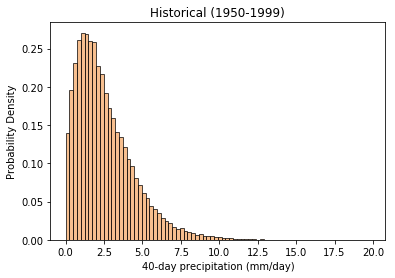

In [34]:
plt.hist(df.value, bins = 80, normed=True, color = 'sandybrown', edgecolor = 'black', alpha = 0.7)
plt.xlabel('40-day precipitation (mm/day)')
plt.ylabel('Probability Density')
plt.title('Historical (1950-1999)')
plt.figure(figsize=(3,4))

In [66]:
from scipy.stats import genextreme as gev
fit = gev.fit(first)

In [67]:
fit

(-0.10291885622343117, 1.6153416237454672, 1.165412736181588)

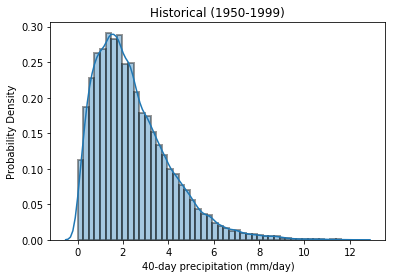

In [27]:
ax = sns.distplot(first, hist_kws=dict(edgecolor="k", linewidth=2))
plt.xlabel('40-day precipitation (mm/day)')
plt.ylabel('Probability Density')
plt.title('Historical (1950-1999)')
plt.show()

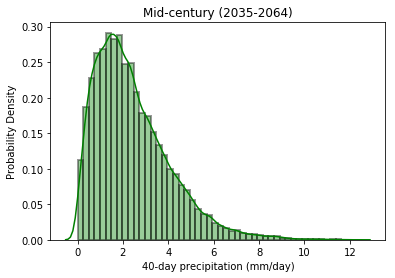

In [62]:
ax = sns.distplot(first, hist_kws=dict(edgecolor="k", linewidth=2), color = 'g')
plt.xlabel('40-day precipitation (mm/day)')
plt.ylabel('Probability Density')
plt.title('Mid-century (2035-2064)')
plt.figure(figsize=(3,4))
#plt.show()

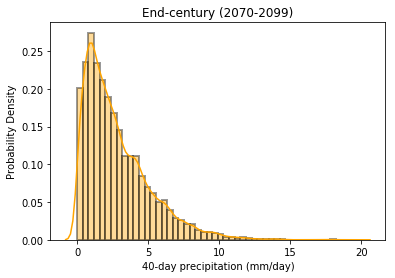

In [65]:
ax = sns.distplot(third, hist_kws=dict(edgecolor="k", linewidth=2), color = 'orange')
plt.xlabel('40-day precipitation (mm/day)')
plt.ylabel('Probability Density')
plt.title('End-century (2070-2099)')
plt.figure(figsize=(3,4))
#plt.show()

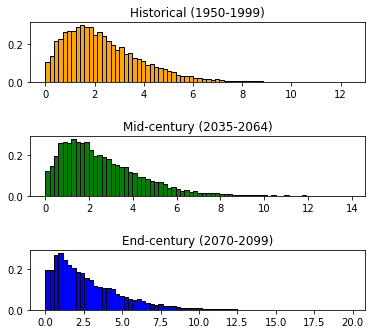

In [61]:
fig = plt.figure()
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

n, bins, patches = ax1.hist(first.value, bins = 70, normed=True, color = 'orange', edgecolor='black')
n, bins, patches = ax2.hist(second.value, bins = 70, normed=True, color = 'g', edgecolor='black')
n, bins, patches = ax3.hist(third.value, bins = 70, normed=True, color = 'b', edgecolor='black')

#ax1.set_xlabel('40-day precipitation (mm/day)')
#ax1.set_ylabel('Probability Density')
ax1.set_title('Historical (1950-1999)')


#ax2.set_xlabel('40-day precipitation (mm/day)')
#ax2.set_ylabel('Probability Density')
ax2.set_title('Mid-century (2035-2064)')

#ax3.set_xlabel('40-day precipitation (mm/day)')
#ax3.set_ylabel('Probability Density')
ax3.set_title('End-century (2070-2099)')
#fig.tight_layout()

plt.subplots_adjust(top = 0.999, bottom=0.001, hspace=0.9, wspace=.1)
#f, axs = plt.subplots(3,3,3,figsize=(15,15))
#f, axs = plt.subplots(2,2,figsize=(15,15))